In [24]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import constants

In [35]:
def save_performance_table(df, metric, output_dir, fname):
    
    os.makedirs(output_dir, exist_ok=True)
    
    grouped_df = df.groupby(['subject_id', 'montage', 'window']).mean()[[metric]]
    grouped_df.reset_index(inplace=True)
    new_df = pd.DataFrame()
    for subject_id in grouped_df.subject_id.unique():
        subset = (grouped_df[grouped_df['subject_id'] == subject_id].copy()).loc[:, ['window', 'montage', metric]].reset_index(drop=True)
        if 'window' in new_df.columns:
            subset = subset.loc[:, [metric]]
        subset.rename({metric: subject_id}, axis=1, inplace=True)
        new_df = pd.concat([new_df, subset], axis=1)
        new_df.groupby(['window', 'montage']).mean().reset_index().to_csv(os.path.join(output_dir, fname), index=False)

# Linear SVM Experiments

## PC

In [63]:
root_dir = os.path.join(constants.RESULTS_DIR, 'motor_LR', 'baseline', 'linear_svm', 'pc')
output_table_dir = os.path.join(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'acc_tables', 'baseline', 'linear_svm', 'pc'))
fname = 'no_selection_test_accuracy_table.csv'

exp_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

df = pd.DataFrame()

for d in exp_dirs:
    if d.startswith('no_select'):
        window = d.split('_')[-1]
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, 'None_results.parquet'))
            temp.loc[:, 'selection_method'] = 'None'
            temp.loc[:, 'window'] = window
        except:
            continue
    else:
        selection_method = d.split('_')[-1]
        window = d.split('_')[2]
        if selection_method in ['mi', 'pca', 'rfe', 'sfs']:
            selection_method = selection_method.upper()
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, f'{selection_method}_results.parquet'))
            temp.loc[:, 'selection_method'] = selection_method
            temp.loc[:, 'window'] = window
        except:
            continue
    df = df.append(temp, ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_cols = [f'Train {m}' for m in metrics]
valid_cols = [f'Valid {m}' for m in metrics]
test_cols = [f'Test {m}' for m in metrics]

# Sort by column values
window_sorter = ['all', '0', '1', '2', '3', '4', '5', '6', '7']
select_sorter = ['None', 'PCA', 'MI']
df.window = df.window.astype('category')
df.window.cat.set_categories(window_sorter, inplace=True)
df.selection_method = df.selection_method.astype('category')
df.selection_method.cat.set_categories(select_sorter, inplace=True)
df.sort_values(['window', 'selection_method'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [64]:
df.groupby(['window', 'selection_method']).mean()[test_cols]

Test Accuracy  Test Precision  Test Recall   Test F1
window selection_method                                                      
all    None                   0.489292        0.489000     0.489370  0.485619
       PCA                    0.487178        0.486832     0.487234  0.483941
       MI                     0.494413        0.494271     0.494374  0.490926
0      None                   0.489362        0.488964     0.489226  0.485556
       PCA                    0.485577        0.485174     0.485473  0.482141
       MI                     0.491674        0.491412     0.491615  0.488093
1      None                   0.489429        0.489007     0.489446  0.485727
       PCA                    0.486218        0.485803     0.486236  0.482568
       MI                     0.491210        0.490840     0.491085  0.487802
2      None                   0.493773        0.493379     0.493673  0.490064
       PCA                    0.491814        0.491367     0.491701  0.488283
       MI                     0.503314        0.503337     0.503247  0.499630
3      None                   0.503775        0.504152     0.503715  0.500142
       PCA                    0.502579        0.502814     0.502540  0.499408
       MI                     0.492681        0.492576     0.492548  0.489196
4      None                   0.490173        0.489755     0.490134  0.486722
       PCA                    0.488945        0.488612     0.489061  0.485474
       MI                     0.495553        0.495459     0.495575  0.492173
5      None                   0.496578        0.496551     0.496661  0.492962
       PCA                    0.499109        0.499293     0.499254  0.495391
       MI                     0.493587        0.493490     0.493634  0.489951
6      None                   0.490489        0.490250     0.490544  0.486884
       PCA                    0.491855        0.491627     0.491962  0.488277
       MI                     0.491773        0.491558     0.491738  0.488312
7      None                   0.495200        0.494850     0.495222  0.491458
       PCA                    0.499143        0.499368     0.499380  0.495968
       MI                     0.494746        0.494554     0.494658  0.491078

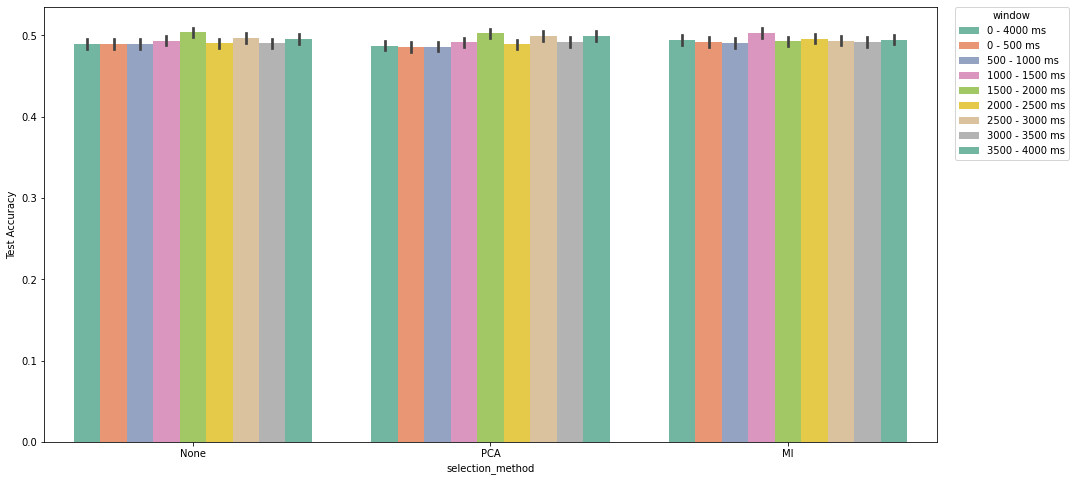

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
window_mapping = {
    'all': '0 - 4000 ms',
    '0': '0 - 500 ms',
    '1': '500 - 1000 ms',
    '2': '1000 - 1500 ms',
    '3': '1500 - 2000 ms',
    '4': '2000 - 2500 ms',
    '5': '2500 - 3000 ms',
    '6': '3000 - 3500 ms',
    '7': '3500 - 4000 ms'
}
plot_df = df.copy()
plot_df['window'].replace(window_mapping, inplace=True)

sns.barplot(data=plot_df, x='selection_method', y='Test Accuracy', hue='window', palette='Set2', ax=ax)
plt.legend(title='window', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

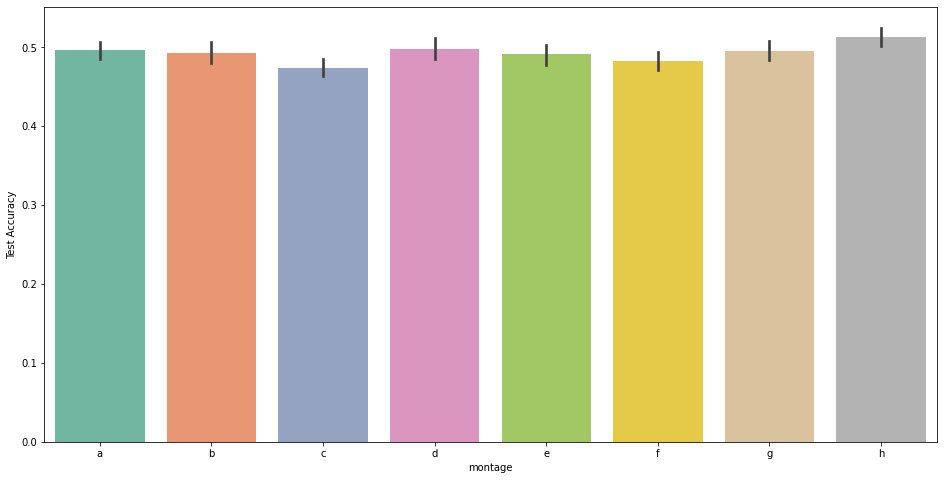

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], x='montage', y='Test Accuracy', palette='Set2', ax=ax);

In [38]:
save_performance_table(df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], 'Test Accuracy', output_table_dir, fname)

## RS

In [48]:
root_dir = os.path.join(constants.RESULTS_DIR, 'motor_LR', 'baseline', 'linear_svm', 'rs')
output_table_dir = os.path.join(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'acc_tables', 'baseline', 'linear_svm', 'rs'))
fname = 'no_selection_test_accuracy_table.csv'

exp_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

df = pd.DataFrame()

for d in exp_dirs:
    if d.startswith('no_select'):
        window = d.split('_')[-1]
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, 'None_results.parquet'))
            temp.loc[:, 'selection_method'] = 'None'
            temp.loc[:, 'window'] = window
        except:
            continue
    else:
        selection_method = d.split('_')[-1]
        window = d.split('_')[2]
        if selection_method in ['mi', 'pca', 'rfe', 'sfs']:
            selection_method = selection_method.upper()
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, f'{selection_method}_results.parquet'))
            temp.loc[:, 'selection_method'] = selection_method
            temp.loc[:, 'window'] = window
        except:
            continue
    df = df.append(temp, ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_cols = [f'Train {m}' for m in metrics]
valid_cols = [f'Valid {m}' for m in metrics]
test_cols = [f'Test {m}' for m in metrics]

# Sort by column values
window_sorter = ['all', '0', '1', '2', '3', '4', '5', '6', '7']
select_sorter = ['None', 'PCA', 'MI']
df.window = df.window.astype('category')
df.window.cat.set_categories(window_sorter, inplace=True)
df.selection_method = df.selection_method.astype('category')
df.selection_method.cat.set_categories(select_sorter, inplace=True)
df.sort_values(['window', 'selection_method'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [49]:
df.groupby(['window', 'selection_method']).mean()[test_cols]

Test Accuracy  Test Precision  Test Recall   Test F1
window selection_method                                                      
all    None                   0.488775        0.488461     0.488681  0.484983
       PCA                    0.491352        0.491114     0.491307  0.487523
       MI                     0.489863        0.489599     0.489842  0.486071
0      None                   0.494429        0.494538     0.494557  0.490531
       PCA                    0.496700        0.497061     0.496964  0.493243
       MI                     0.490873        0.490636     0.490759  0.487027
1      None                   0.494446        0.494350     0.494453  0.490775
       PCA                    0.498845        0.498624     0.498846  0.495555
       MI                     0.492644        0.492448     0.492733  0.488973
2      None                   0.491464        0.491119     0.491187  0.487719
       PCA                    0.490397        0.489918     0.490179  0.486942
       MI                     0.492162        0.491811     0.491847  0.488178
3      None                   0.493769        0.493422     0.493710  0.490335
       PCA                    0.493824        0.493560     0.493765  0.490809
       MI                     0.490674        0.490260     0.490657  0.486950
4      None                   0.495706        0.495575     0.495753  0.491769
       PCA                    0.495049        0.494975     0.495076  0.491351
       MI                     0.495070        0.494886     0.494935  0.491068
5      None                   0.500381        0.500405     0.500281  0.496659
       PCA                    0.500401        0.500489     0.500439  0.496693
       MI                     0.494557        0.494180     0.494380  0.490793
6      None                   0.490583        0.490338     0.490431  0.486630
       PCA                    0.490409        0.490435     0.490417  0.486524
       MI                     0.491286        0.490735     0.491169  0.487236
7      None                   0.497906        0.497636     0.497702  0.494397
       PCA                    0.499205        0.498865     0.499089  0.495377
       MI                     0.502024        0.501997     0.501923  0.498152

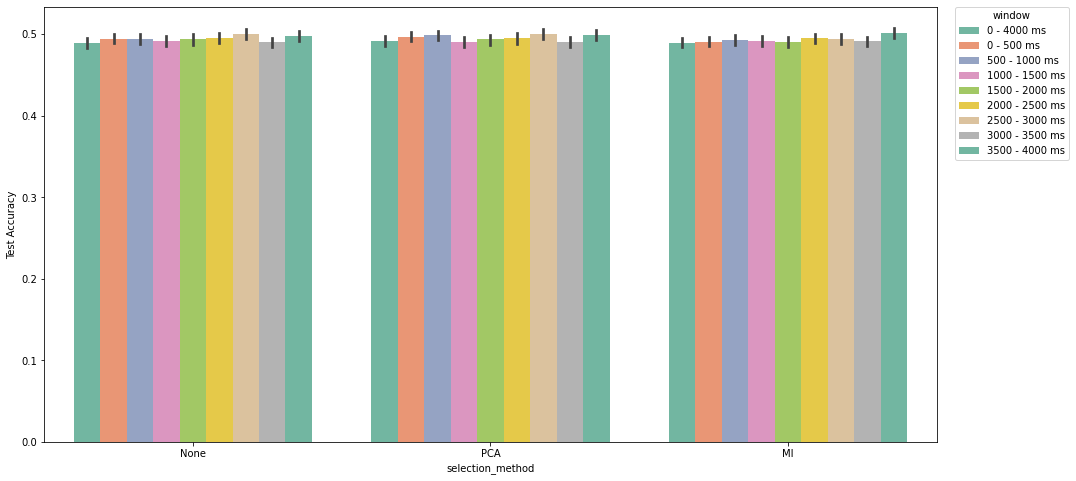

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
window_mapping = {
    'all': '0 - 4000 ms',
    '0': '0 - 500 ms',
    '1': '500 - 1000 ms',
    '2': '1000 - 1500 ms',
    '3': '1500 - 2000 ms',
    '4': '2000 - 2500 ms',
    '5': '2500 - 3000 ms',
    '6': '3000 - 3500 ms',
    '7': '3500 - 4000 ms'
}
plot_df = df.copy()
plot_df['window'].replace(window_mapping, inplace=True)

sns.barplot(data=plot_df, x='selection_method', y='Test Accuracy', hue='window', palette='Set2', ax=ax)
plt.legend(title='window', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

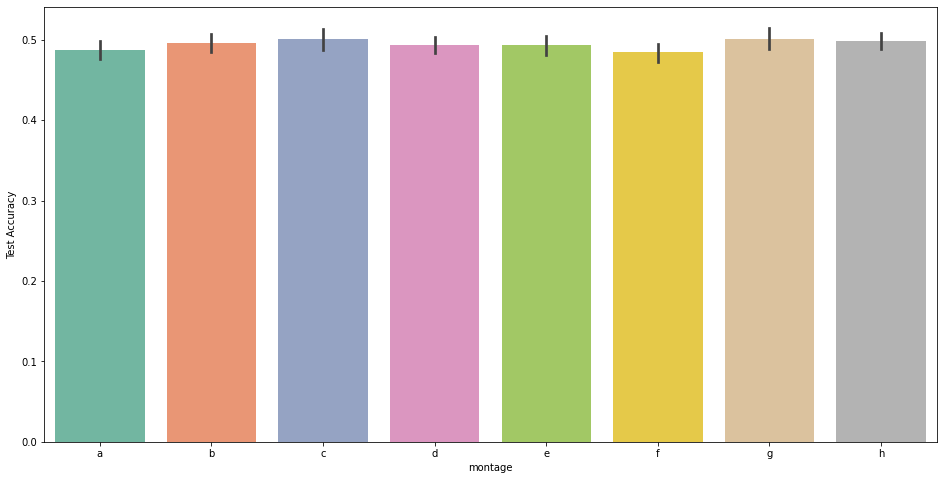

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], x='montage', y='Test Accuracy', palette='Set2', ax=ax);

In [44]:
save_performance_table(df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], 'Test Accuracy', output_table_dir, fname)

# RBF SVM Experiments

## PC

In [58]:
root_dir = os.path.join(constants.RESULTS_DIR, 'motor_LR', 'baseline', 'rbf_svm', 'pc')
output_table_dir = os.path.join(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'acc_tables', 'baseline', 'rbf_svm', 'pc'))
fname = 'no_selection_test_accuracy_table.csv'

exp_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

df = pd.DataFrame()

for d in exp_dirs:
    if d.startswith('no_select'):
        window = d.split('_')[-1]
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, 'None_results.parquet'))
            temp.loc[:, 'selection_method'] = 'None'
            temp.loc[:, 'window'] = window
        except:
            continue
    else:
        selection_method = d.split('_')[-1]
        window = d.split('_')[2]
        if selection_method in ['mi', 'pca', 'rfe', 'sfs']:
            selection_method = selection_method.upper()
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, f'{selection_method}_results.parquet'))
            temp.loc[:, 'selection_method'] = selection_method
            temp.loc[:, 'window'] = window
        except:
            continue
    df = df.append(temp, ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_cols = [f'Train {m}' for m in metrics]
valid_cols = [f'Valid {m}' for m in metrics]
test_cols = [f'Test {m}' for m in metrics]

# Sort by column values
window_sorter = ['all', '0', '1', '2', '3', '4', '5', '6', '7']
select_sorter = ['None', 'PCA', 'MI']
df.window = df.window.astype('category')
df.window.cat.set_categories(window_sorter, inplace=True)
df.selection_method = df.selection_method.astype('category')
df.selection_method.cat.set_categories(select_sorter, inplace=True)
df.sort_values(['window', 'selection_method'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [59]:
df.groupby(['window', 'selection_method']).mean()[test_cols]

Test Accuracy  Test Precision  Test Recall   Test F1
window selection_method                                                      
all    None                   0.474079        0.415291     0.471783  0.406450
       PCA                    0.467660        0.462456     0.467217  0.455582
       MI                     0.479859        0.450256     0.478191  0.429858
0      None                   0.476582        0.468756     0.475415  0.454792
       PCA                    0.472578        0.468153     0.472015  0.462227
       MI                     0.486229        0.479243     0.485261  0.462010
1      None                   0.478594        0.473151     0.478085  0.459910
       PCA                    0.479652        0.476240     0.479425  0.470972
       MI                     0.489247        0.484454     0.488798  0.467433
2      None                   0.496967        0.492504     0.495898  0.477847
       PCA                    0.493419        0.490769     0.492938  0.483125
       MI                     0.494966        0.490652     0.494022  0.471480
3      None                   0.485914        0.480277     0.485076  0.465494
       PCA                    0.488943        0.486738     0.488602  0.479574
       MI                     0.492835        0.488763     0.492310  0.470278
4      None                   0.482766        0.477051     0.482168  0.463353
       PCA                    0.482910        0.479377     0.482533  0.472724
       MI                     0.487212        0.482104     0.486691  0.465763
5      None                   0.486787        0.484509     0.486067  0.465773
       PCA                    0.487887        0.485828     0.487611  0.477320
       MI                     0.488208        0.482450     0.487512  0.463161
6      None                   0.485099        0.479501     0.484620  0.464417
       PCA                    0.490807        0.486789     0.490545  0.480157
       MI                     0.490483        0.484259     0.489873  0.466532
7      None                   0.488315        0.483630     0.487788  0.469522
       PCA                    0.486563        0.482813     0.486378  0.476378
       MI                     0.492897        0.487254     0.492281  0.467742

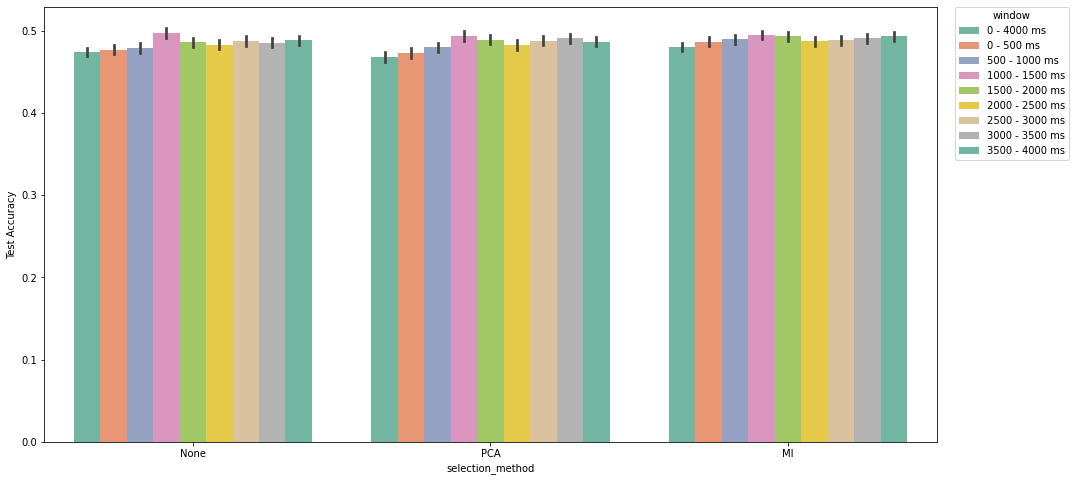

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
window_mapping = {
    'all': '0 - 4000 ms',
    '0': '0 - 500 ms',
    '1': '500 - 1000 ms',
    '2': '1000 - 1500 ms',
    '3': '1500 - 2000 ms',
    '4': '2000 - 2500 ms',
    '5': '2500 - 3000 ms',
    '6': '3000 - 3500 ms',
    '7': '3500 - 4000 ms'
}
plot_df = df.copy()
plot_df['window'].replace(window_mapping, inplace=True)

sns.barplot(data=plot_df, x='selection_method', y='Test Accuracy', hue='window', palette='Set2', ax=ax)
plt.legend(title='window', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

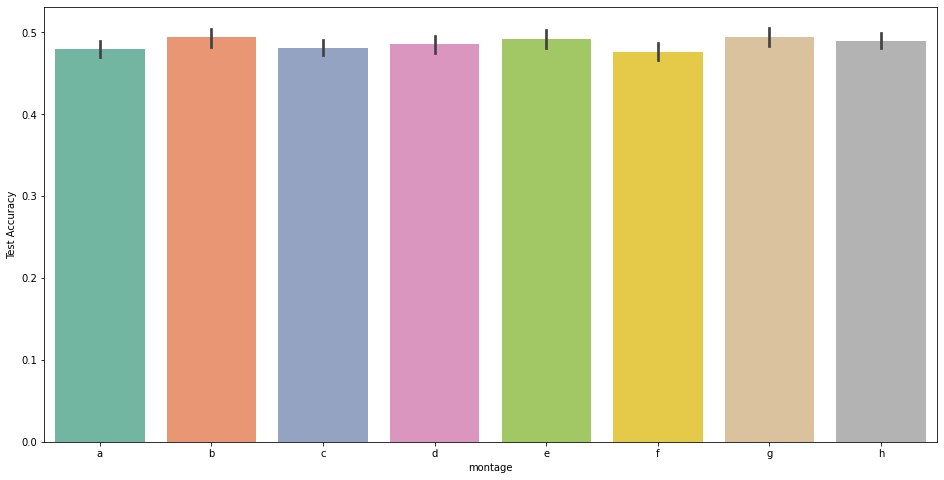

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], x='montage', y='Test Accuracy', palette='Set2', ax=ax);

In [62]:
save_performance_table(df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], 'Test Accuracy', output_table_dir, fname)

## RS

In [53]:
root_dir = os.path.join(constants.RESULTS_DIR, 'motor_LR', 'baseline', 'rbf_svm', 'rs')
output_table_dir = os.path.join(os.path.join(constants.RESULTS_DIR, 'motor_LR', 'acc_tables', 'baseline', 'rbf_svm', 'rs'))
fname = 'no_selection_test_accuracy_table.csv'

exp_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

df = pd.DataFrame()

for d in exp_dirs:
    if d.startswith('no_select'):
        window = d.split('_')[-1]
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, 'None_results.parquet'))
            temp.loc[:, 'selection_method'] = 'None'
            temp.loc[:, 'window'] = window
        except:
            continue
    else:
        selection_method = d.split('_')[-1]
        window = d.split('_')[2]
        if selection_method in ['mi', 'pca', 'rfe', 'sfs']:
            selection_method = selection_method.upper()
        try:
            temp = pd.read_parquet(os.path.join(root_dir, d, f'{selection_method}_results.parquet'))
            temp.loc[:, 'selection_method'] = selection_method
            temp.loc[:, 'window'] = window
        except:
            continue
    df = df.append(temp, ignore_index=True)

metrics = ['Accuracy', 'Precision', 'Recall', 'F1']
train_cols = [f'Train {m}' for m in metrics]
valid_cols = [f'Valid {m}' for m in metrics]
test_cols = [f'Test {m}' for m in metrics]

# Sort by column values
window_sorter = ['all', '0', '1', '2', '3', '4', '5', '6', '7']
select_sorter = ['None', 'PCA', 'MI']
df.window = df.window.astype('category')
df.window.cat.set_categories(window_sorter, inplace=True)
df.selection_method = df.selection_method.astype('category')
df.selection_method.cat.set_categories(select_sorter, inplace=True)
df.sort_values(['window', 'selection_method'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [54]:
df.groupby(['window', 'selection_method']).mean()[test_cols].round(3)

Test Accuracy  Test Precision  Test Recall  Test F1
window selection_method                                                     
all    None                      0.480           0.385        0.475    0.386
       PCA                       0.467           0.459        0.465    0.452
       MI                        0.488           0.404        0.484    0.404
0      None                      0.483           0.473        0.481    0.460
       PCA                       0.480           0.477        0.479    0.471
       MI                        0.489           0.482        0.487    0.465
1      None                      0.500           0.499        0.499    0.480
       PCA                       0.497           0.495        0.496    0.487
       MI                        0.497           0.494        0.496    0.476
2      None                      0.492           0.485        0.491    0.471
       PCA                       0.497           0.494        0.496    0.487
       MI                        0.496           0.490        0.495    0.475
3      None                      0.488           0.483        0.486    0.467
       PCA                       0.489           0.488        0.489    0.480
       MI                        0.495           0.491        0.493    0.473
4      None                      0.497           0.492        0.495    0.476
       PCA                       0.497           0.494        0.496    0.486
       MI                        0.497           0.491        0.496    0.471
5      None                      0.493           0.487        0.492    0.469
       PCA                       0.495           0.494        0.494    0.484
       MI                        0.499           0.496        0.497    0.477
6      None                      0.491           0.487        0.489    0.472
       PCA                       0.489           0.487        0.488    0.479
       MI                        0.487           0.479        0.485    0.463
7      None                      0.488           0.482        0.487    0.467
       PCA                       0.486           0.484        0.485    0.477
       MI                        0.494           0.487        0.493    0.472

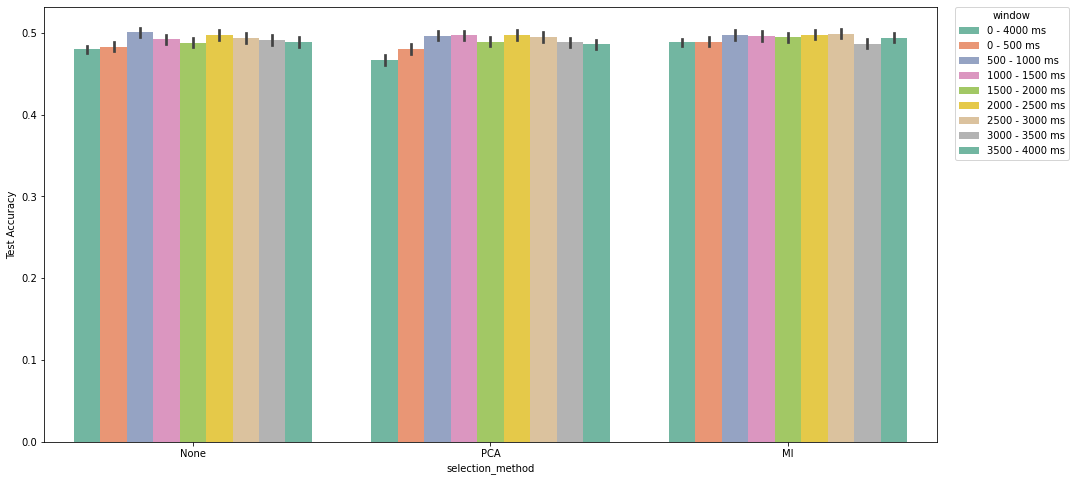

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))
window_mapping = {
    'all': '0 - 4000 ms',
    '0': '0 - 500 ms',
    '1': '500 - 1000 ms',
    '2': '1000 - 1500 ms',
    '3': '1500 - 2000 ms',
    '4': '2000 - 2500 ms',
    '5': '2500 - 3000 ms',
    '6': '3000 - 3500 ms',
    '7': '3500 - 4000 ms'
}
plot_df = df.copy()
plot_df['window'].replace(window_mapping, inplace=True)

sns.barplot(data=plot_df, x='selection_method', y='Test Accuracy', hue='window', palette='Set2', ax=ax)
plt.legend(title='window', bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.);

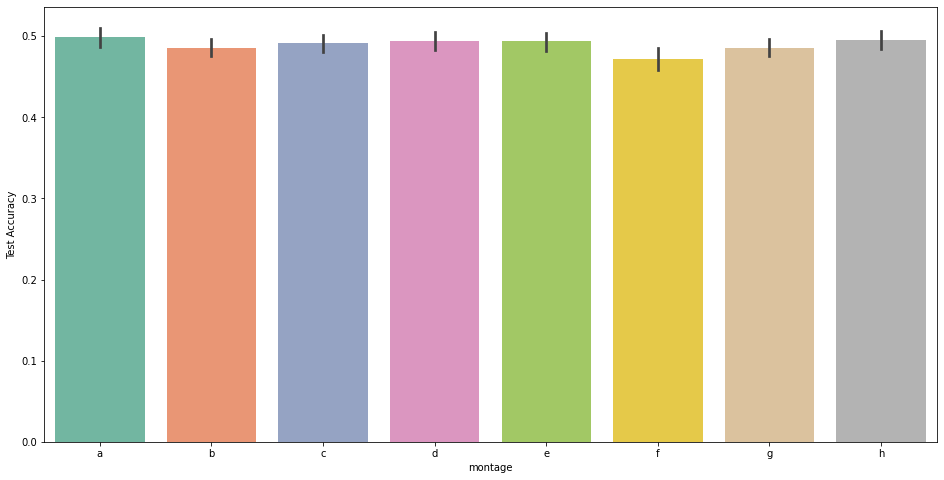

In [56]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

sns.barplot(data=df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], x='montage', y='Test Accuracy', palette='Set2', ax=ax);

In [57]:
save_performance_table(df[((df['window'] == '6') | (df['window'] == '7')) & (df['selection_method'] == 'None')], 'Test Accuracy', output_table_dir, fname)